In [1]:
import sys
import matplotlib.pyplot as plt
import h5py
from tqdm import tqdm
import librosa
import numpy as np
from keras.utils.np_utils import to_categorical
from sklearn.utils import shuffle
import cv2
import torch
import torchaudio

from tools import prepare, mixup, preprocess, noise, getCorrects

ufs_classes2 = {
    "Rhinolophus capensis": 0,
    "Rhinolophus smithersi": 1,
    "Rhinolophus clivosus": 2,
    "Rhinolophus simulator": 3,
    "Myotis tricolor": 4,
    "Myotis welwitschii": 5,
    "Pipistrellus hesperidus": 6,
    "Eptesicus hottentotus": 7,
    "Minopterus natalensis": 8,
    "Taphozous mauritianus": 9,
    "Scotophilus dinganii": 10,
    "Cistugo lesueuri": 11,
    "Laephotis capensis": 12,
    "Rousettus aegyptiacus": 13,
    "Chaerephon pumilus": 14,
    "Tadarida aegyptiaca": 15,
    "Vespertilionidae": 16,
    "Kerivoula": 17,
    "Pesticide Spray": 18,
    "Unlabeled": 19,
}

ufs_classes = {
    #"Rhinolophus capensis": 0,
    #"Rhinolophus smithersi": 1,
    #"Rhinolophus clivosus": 2,
    #"Rhinolophus simulator": 3,
    #"Myotis tricolor": 4,
    #"Myotis welwitschii": 5,
    "Pipistrellus hesperidus": 0,
    #"Eptesicus hottentotus": 7,
    #"Minopterus natalensis": 8,
    #"Taphozous mauritianus": 9,
    #"Scotophilus dinganii": 10,
    "Cistugo lesueuri": 1,
    "Laephotis capensis": 2,
    #"Rousettus aegyptiacus": 13,
    "Chaerephon pumilus": 3,
    "Tadarida aegyptiaca": 4,
    #"Vespertilionidae": 16,
    #"Kerivoula": 17,
    #"Pesticide Spray": 18,
    "Unlabeled": 5,
}

2022-12-01 10:27:06.559357: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-01 10:27:06.991453: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-01 10:27:09.818358: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ffundel/.local/lib:
2022-12-01 10:27:09.818647: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cann

In [2]:
num_bands = 257
max_len = 60
seq_len = (max_len + 1) * 2816      # = 250ms ~ 25ms (0.5 * 44 * (512 // 4))
seq_skip = int(max_len / 4) * 2816     # 15 patches = 15 * 0.25 * 22050 * 0.5
patch_len = 44
patch_skip = 22

data_path = "./data/prepared_signal.h5"
X_train, Y_train, X_test, Y_test, X_val, Y_val = prepare(data_path, ufs_classes, seq_len, seq_skip)

100%|█████████████████████████████████████████████| 8/8 [00:02<00:00,  3.02it/s]


In [3]:
print("Total sequences:", len(X_train) + len(X_test) + len(X_val))
print("Train sequences:", X_train.shape, Y_train.shape)
print("Test sequences:", X_test.shape, Y_test.shape)
print("Validation sequences:", X_val.shape, Y_val.shape)

Total sequences: 61557
Train sequences: (36390, 171776) (36390, 6)
Test sequences: (15436, 171776) (15436, 6)
Validation sequences: (9731, 171776) (9731, 6)


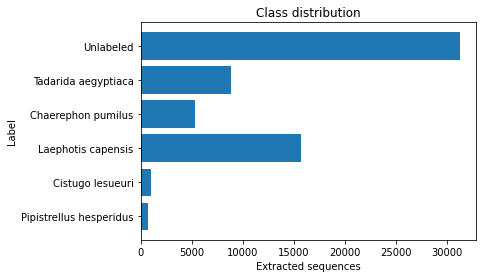

In [4]:
spec_count = np.zeros(len(list(ufs_classes)))
for label in np.concatenate([Y_train, Y_test, Y_val]):
    spec_count[np.nonzero(label)] += 1

plt.barh(list(ufs_classes), spec_count)
plt.ylabel("Label")
plt.xlabel("Extracted sequences")
plt.title("Class distribution")
plt.show()

In [8]:
print(spec_count)

[  709.   961. 15687.  5328.  8859. 31256.]


In [5]:
import csv

time_data = [[] for _ in ufs_classes]
date_data = [[] for _ in ufs_classes]
temp_data = [[] for _ in ufs_classes]
loc_data = [[] for _ in ufs_classes]

with open('meta_n.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=';')
    next(reader)
    for row in reader:
        species = row[24]
        time = int(row[5].split(':')[0]) # hh:mm:ss to h
        date = int(row[4].split('-')[1]) # yyyy-mm-dd to m
        temp = float(row[12])
        loc = [float(row[10]), float(row[11])]
        
        for s in species.split(','):
            if s in ufs_classes:
                i = ufs_classes[s]
                time_data[i].append(time)
                date_data[i].append(date)
                temp_data[i].append(temp)
                loc_data[i].append(loc)

for c, _ in enumerate(loc_data):
    loc_data[c] = np.asarray(loc_data[c])

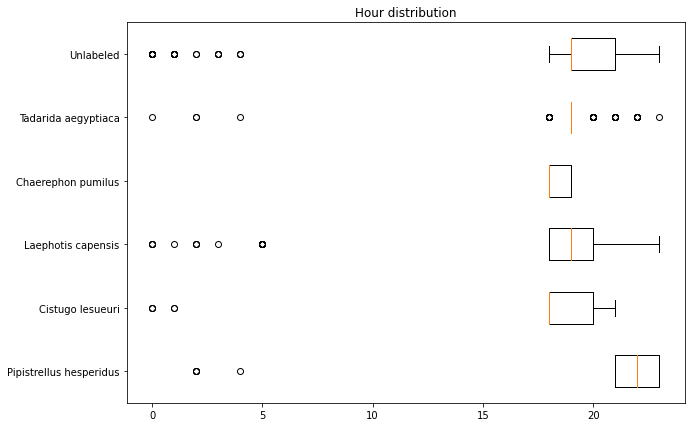

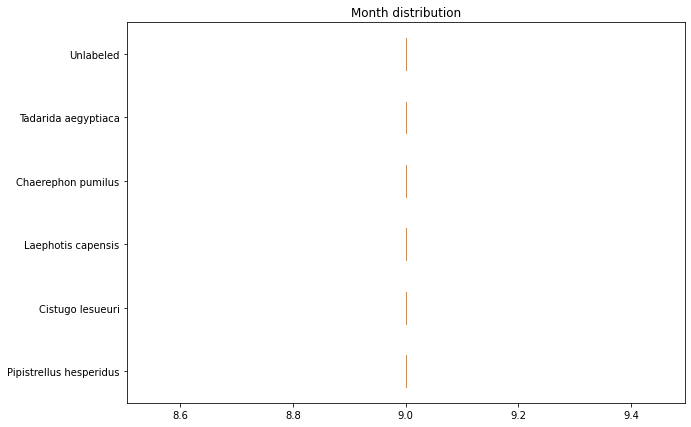

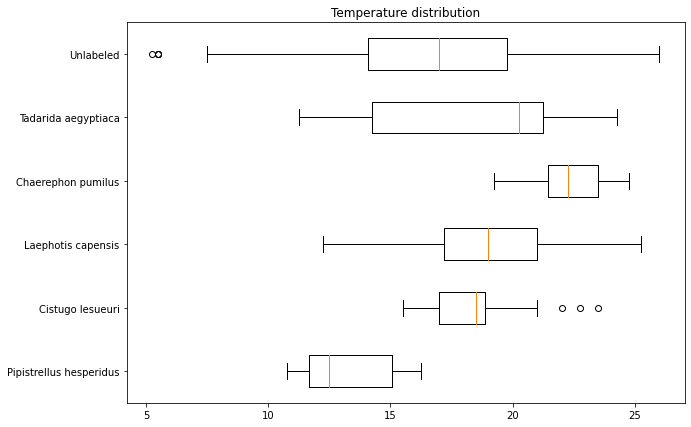

In [6]:
# For each class: avg time boxplot, avg temperatur boxplot
# weather matrix, geo matrix
# location on map

fig = plt.figure(figsize =(10, 7))
plt.boxplot(time_data, labels=list(ufs_classes), vert=False)
plt.title("Hour distribution")
plt.show()

fig = plt.figure(figsize =(10, 7))
plt.boxplot(date_data, labels=list(ufs_classes), vert=False)
plt.title("Month distribution")
plt.show()

fig = plt.figure(figsize =(10, 7))
plt.boxplot(temp_data, labels=list(ufs_classes), vert=False)
plt.title("Temperature distribution")
plt.show()

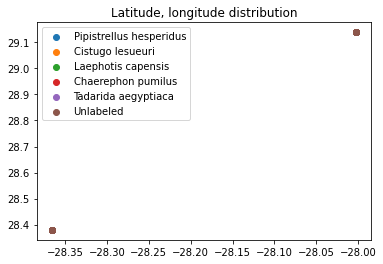

In [7]:
for i, locs in enumerate(loc_data):
    plt.scatter(locs[:, 0], locs[:, 1], label=list(ufs_classes)[i])

plt.legend(loc='upper left')
plt.title("Latitude, longitude distribution")
plt.show()